In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import keyedvectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Connect to database

In [3]:
#Load database
conn = sqlite3.connect('amazon_food_reviews.sqlite')

original_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3""", conn)

original_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data preprocessing

In [4]:
# Replace number rating with positive and negative strings
print(f'Size after droping duplicates {original_data.size}')
original_data = original_data.drop_duplicates({"UserId", "ProfileName", "Time", "Text"})

original_data["Score"] = original_data["Score"].map(lambda x: "positive" if x > 3 else "negative")
print(f'Size before droping duplicates {original_data.size}')

Size after droping duplicates 5258140
Size before droping duplicates 3641730


In [5]:
original_data = original_data[original_data.HelpfulnessDenominator >= original_data.HelpfulnessNumerator]
print(f'Size after droping Helpfulness denominator greater than Numerator {original_data.size}')

Size after droping Helpfulness denominator greater than Numerator 3641710


In [6]:
#Number of positive and negative reviews
original_data["Score"].value_counts()


positive    307061
negative     57110
Name: Score, dtype: int64

#### We are concerned only about the Reviews and the score column so extract those in to a new variable

In [7]:
filtered_data = original_data.loc[:,["Time","Score","Text"]]

np_random_perm = np.random.permutation(30000)

filtered_data = filtered_data[filtered_data.Score == "positive"].iloc[np_random_perm, :]. \
                    append(filtered_data[filtered_data.Score == "negative"].iloc[np_random_perm, :])

filtered_data = filtered_data.sort_values(by=['Time'])

print(filtered_data.shape)
print(filtered_data.isnull().any())
print(filtered_data.head())
print(filtered_data.tail())

(60000, 3)
Time     False
Score    False
Text     False
dtype: bool
              Time     Score  \
212458   948240000  negative   
1146     961718400  positive   
1145     962236800  positive   
212454   997228800  negative   
212457  1040947200  negative   

                                                     Text  
212458  I, myself always enjoyed this movie, it's very...  
1146    This was a really good idea and the final prod...  
1145    I just received my shipment and could hardly w...  
212454  I am continually amazed at the shoddy treatmen...  
212457  Just to let you know, this movie is one of my ...  
              Time     Score  \
200230  1351209600  negative   
129898  1351209600  negative   
106015  1351209600  negative   
7451    1351209600  negative   
14300   1351209600  positive   

                                                     Text  
200230  I had high expectations of these seeds, but I ...  
129898  The coffee is excellent and I am a repeat buye...  
106015

## Text preprocessing : Remove Html Tags, Punctuations, alphanumerics and stop words. 

1. Obtain stem words for the remaining words and run algorithm using the data
2. Obtain lemma for each word and run algorithm using the data

In [8]:
# Code copied from the description python note book

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|-]',r' ',cleaned)
    return  cleaned

#### Clean the reviews

In [9]:
processed_reviews=[]

for (index, review) in enumerate(filtered_data["Text"].values):
    processedReviewWords = []
    cleanedReview = cleanpunc(cleanhtml(review))
    for word in cleanedReview.split():
        word_in_lowercase = word.lower()
        if(word_in_lowercase.isalpha and \
           (word_in_lowercase not in stop) and \
           len(word_in_lowercase)>2):
            processedReviewWords.append(sno.stem(word_in_lowercase).encode('utf8'))
    processed_reviews.append(b" ".join(processedReviewWords))
    
print(processed_reviews[:5])

[b'alway enjoy movi funni entertain didnt hesit pick clamshel edit guess market plan make movi famili someth elimin strong profan element usual edit televis version warn want uncut version avoid clamshel edit', b'realli good idea final product outstand use decal car window everybodi ask bought decal made two thumb', b'receiv shipment could hard wait tri product love &quot;slickers&quot; call instead sticker remov easili daughter design sign print revers use car window print beauti print shop program go lot fun product window everywher surfac like screen comput monitor', b'continu amaz shoddi treatment movi get dvd releas dvd simpli disgrac especi consid great movi give movi stars; wonder exampl tim burton energi style dvd extra worth mention delet scene featurett even lousi commentari track make even wors film cut theatric releas never seen dvd releas get less origin present theater advic save money somebodi figur movi releas dvd need live capabl medium alway provid materi origin relea

#### Append the cleaned text to the table with the normal text

In [10]:
filtered_data["CleanedText"] = processed_reviews
filtered_data["CleanedText"] = filtered_data["CleanedText"].str.decode("utf-8")
filtered_data.head()

,Time,Score,Text,CleanedText
212458,948240000,negative,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
1146,961718400,positive,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,962236800,positive,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
212454,997228800,negative,I am continually amazed at the shoddy treatmen...,continu amaz shoddi treatment movi get dvd rel...
212457,1040947200,negative,"Just to let you know, this movie is one of my ...",let know movi one person favorit ghost movi sa...


#### Import libraries for Clasification

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [157]:
from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(filtered_data['Score'], classes=['negative','positive']) # ham will be 0 and spam will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array

## Split data in to train and test

In [158]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(filtered_data["CleanedText"], encoded_labels,\
                                                                     test_size=0.3, random_state=0)

## Common Functions definitions

In [192]:
def ColumnStandardization(train_data, test_data):
    """ Column standardization to get unit variance.
    with_mean is set to false so that it works for sparse matrix
    """
    standardizer = StandardScaler(with_mean=False)
    std_train_data = standardizer.fit_transform(train_data)
    std_test_data = standardizer.transform(test_data)
    return (std_train_data, std_test_data)

In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

In [13]:
def DecisionTreeGridSearch(train_features, train_class, test_features, test_class):
    
    depths = list(range(2,300))
    
    hyper_parameters ={'max_depth': depths}
    
    time_series_cv = TimeSeriesSplit(n_splits=5)
    
    model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), hyper_parameters, cv=time_series_cv, \
                                        scoring='f1', verbose=1, n_jobs = -1)
    
    model.fit(train_features, train_class)
    print(model.best_estimator_)
    f1 = model.score(test_features, test_class) * float(100)
    
    predictions = model.predict(test_features)

    acc = accuracy_score(test_class, predictions) * float(100)
    precision = precision_score(test_class, predictions) * float(100)
    recall = recall_score(test_class, predictions) * float(100)
    
    print(f'Accuracy = {acc}') 
    print(f'F1 Score = {f1}') 
    print(f'Precision = {precision}') 
    print(f'Recall = {recall}') 
    
    plt.figure(1)

    x=[]
    y=[]
    for a in model.grid_scores_:
        x.append(a[0]['max_depth']) 
        y.append(a[1])
    plt.xlim(-10,300)
    plt.ylim(0.2,1.0)
    plt.xlabel(r"max depth",fontsize=15)
    plt.ylabel("f1")
    plt.title(r'f1 v/s Max Depth')
    plt.plot(x,y)
    plt.show()
    
    df_cm = pd.DataFrame(data=confusion_matrix(test_class, predictions),index=range(2),columns= ['Negative','Positive'])
    
    plt.figure(2)
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

    return model

### Bag Of Words

In [195]:
count_vectorizer = CountVectorizer(ngram_range=(1,3), min_df=5)

#fit and transform train data
bow_X_tr = count_vectorizer.fit_transform(X_train)

# transform test data, note that i am not fitting the vectorizer just transforming the test data
bow_X_test = count_vectorizer.transform(X_test)

(bow_X_tr, bow_X_test) = ColumnStandardization(bow_X_tr, bow_X_test)

print(type(bow_X_tr))
print(f"Shape of final_bigrams : {bow_X_tr.get_shape()}")

<class 'scipy.sparse.csr.csr_matrix'>
Shape of final_bigrams : (42000, 69090)


#### Run Classifier

### Feature Importance

In [7]:
def GetImportantFeatures(classifier, vectorizer, input_features, input_class_labels):
    classifier.fit(input_features, input_class_labels)
    feature_names = np.array(vectorizer.get_feature_names())
    
    feature_names = np.vstack((feature_names, classifier.feature_log_prob_)).T
    
    df_negative = pd.DataFrame(data=feature_names[:,[0,1]], columns=['Features', 'Probabilities'])
    df_positive = pd.DataFrame(data=feature_names[:,[0,2]], columns=['Features', 'Probabilities'])
    
    df_negative.sort_values(by=['Probabilities'], ascending=False, inplace=True)
    df_positive.sort_values(by=['Probabilities'], ascending=False, inplace=True)
    return (df_negative, df_positive)

### Top 20 Words contributing to the Negative reviews

In [198]:
(negative_features, positive_features) = GetImportantFeatures(multinomialClassifier, count_vectorizer, bow_X_tr, Y_train)

In [199]:
negative_features.head(20)

,Features,Probabilities
44140,part,-9.999934079568273
37427,manufactur,-9.999699738367545
60201,tell,-9.999534212802978
38649,mistak,-9.997642808593895
53591,show,-9.992719615099176
12794,contact,-9.989699942031123
52013,saw,-9.989510202652585
49151,realiz,-9.989242161703269
40580,next,-9.987612687254492
44849,perhap,-9.984816220803003


### Top 20 words contributing to Positive reviews

In [200]:
positive_features.head(20)

,Features,Probabilities
35064,live,-9.99848363863428
66403,week,-9.998443383102554
13772,coupl,-9.997220432835284
30210,ice,-9.996491965225047
1866,altern,-9.995454678217834
38515,minut,-9.993136405021954
18394,easili,-9.991714496210122
7600,breakfast,-9.99093437305366
68812,yet,-9.990530118678631
26117,gluten,-9.986644135574881


### TFIDF

In [201]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tfidf_X_tr = tfidf_vectorizer.fit_transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)
(tfidf_X_tr, tfidf_X_test) = ColumnStandardization(tfidf_X_tr, tfidf_X_test)
print(type(tfidf_X_tr))
print(f"Shape of final_bigrams : {tfidf_X_tr.get_shape()}")

<class 'scipy.sparse.csr.csr_matrix'>
Shape of final_bigrams : (42000, 60455)


Optimal Alpha 1000


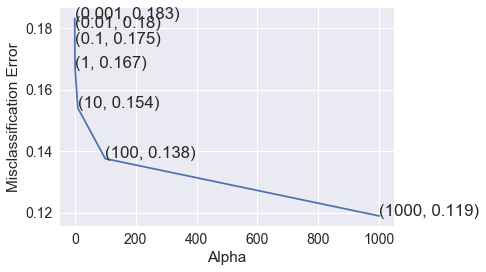

the misclassification error for each Alpha value is :  [0.183 0.18  0.175 0.167 0.154 0.138 0.119]
Accuracy using Multinomial Naive Bayes method 87.67222222222222
F1 Score using Multinomial Naive Bayes method 87.49224959134209
Precision using Multinomial Naive Bayes method 88.06308861908543
Recall using Multinomial Naive Bayes method 86.92876344086021


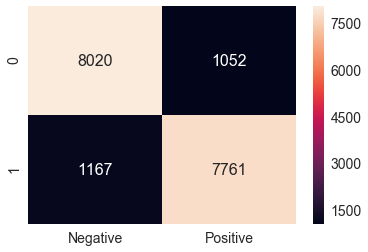

In [202]:
multinomialClassifier = NaiveBayesClassifierForOptimalAplha(train_features = tfidf_X_tr, train_class = Y_train, \
                                     test_features = tfidf_X_test, test_class = Y_test)


In [203]:
(negative_features_tfidf, positive_features_tfidf) = GetImportantFeatures(multinomialClassifier, tfidf_vectorizer, \
                                                                        tfidf_X_tr, Y_train)

In [204]:
negative_features_tfidf.head(20)

,Features,Probabilities
47073,similar,-9.999699077025802
45464,save money,-9.996288774272339
54390,told,-9.994931398334591
34749,name,-9.994218874395958
60376,yuck,-9.993878524746128
5554,black,-9.993270253859814
49902,strang,-9.992117352615569
26794,inform,-9.989538501778
22052,garbag,-9.9892514824452
56150,unpleas,-9.987810442412306


In [205]:
positive_features_tfidf.head(20)

,Features,Probabilities
39308,pick,-9.999676921698267
27240,isnt,-9.998981719865839
58761,white,-9.997986203664249
25253,healthier,-9.997859901548782
13070,daili,-9.99661184322489
49602,stock,-9.995636200673774
39334,picki,-9.994531823550572
22634,gift,-9.993638746276405
33239,microwav,-9.993157746761012
38466,pancak,-9.9919038303605


In [60]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [55]:
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|-]',r' ',cleaned)
    return  cleaned

In [56]:
def Get_List_of_Sentences(cleanedText):
    list_of_sent=[]
    for sent in cleanedText:
        list_of_sent.append(cleanpunc(sent).split())
    return list_of_sent

In [57]:
def Get_Word2Vec_Vectors(list_of_sent):
    w2v_model = Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    return w2v_model

In [58]:
def GetAvgW2V_Vectors(list_of_sent, w2v_model):
    w2v_words = list(w2v_model.wv.vocab)
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    
    return sent_vectors

In [61]:
X_tr_listOfSent = Get_List_of_Sentences(X_train)
X_test_listOfSent = Get_List_of_Sentences(X_test)
X_tr_w2vModel = Get_Word2Vec_Vectors(X_tr_listOfSent)

In [62]:
# Get Average word2vec vector for each set of data -> Column standardize those vectors
avg_X_tr = GetAvgW2V_Vectors(X_tr_listOfSent, X_tr_w2vModel)
avg_X_test = GetAvgW2V_Vectors(X_test_listOfSent, X_tr_w2vModel)
(avg_X_tr, avg_X_test) = ColumnStandardization(avg_X_tr, avg_X_test)

In [63]:
def GetTfIdfW2V_Vectors(list_of_sent, w2v_model, final_tfidf):
    # TF-IDF weighted Word2Vec
    tfidf_feat = tfidf_vectorizer.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
    w2v_words = list(w2v_model.wv.vocab)
    print(f'number of sentences = {len(list_of_sent)}')
    for (row,sent) in enumerate(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if (word in w2v_words) and (word in tfidf_feat):
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = final_tfidf[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        print(f'Sentence number {row}', end = "\r")
    
    return tfidf_sent_vectors

In [64]:
# Get Average word2vec vector for each set of data -> Column standardize those vectors
avgtfidf_X_tr = GetTfIdfW2V_Vectors(X_tr_listOfSent, X_tr_w2vModel, tfidf_X_tr)

number of sentences = 42000


In [65]:
avgtfidf_X_test = GetTfIdfW2V_Vectors(X_test_listOfSent, X_tr_w2vModel, tfidf_X_test)
(avgtfidf_X_tr, avgtfidf_X_test) = ColumnStandardization(avgtfidf_X_tr, avgtfidf_X_test)

number of sentences = 18000


In [2]:
#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [4]:
bow_X_tr_reduced = openfromfile(r'D:\Studies\AppliedAi\AmazonFoodReviews\bow_X_tr')
bow_X_test_reduced = openfromfile(r'D:\Studies\AppliedAi\AmazonFoodReviews\bow_X_test')

In [12]:
count_vectorizer = openfromfile(r'D:\Studies\AppliedAi\AmazonFoodReviews\count_vectorizer')

Fitting 5 folds for each of 298 candidates, totalling 1490 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 107.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 188.6min
[Parallel(n_jobs=-1)]: Done 1490 out of 1490 | elapsed: 233.5min finished


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=46, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy = 76.06111111111112
F1 Score = 74.18369180995745
Precision = 71.85468895078922
Recall = 76.6687306501548


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


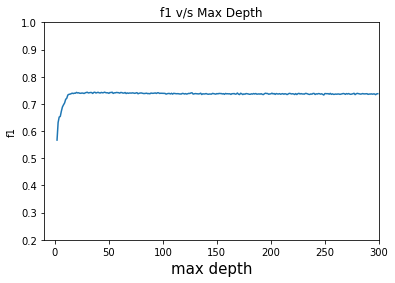

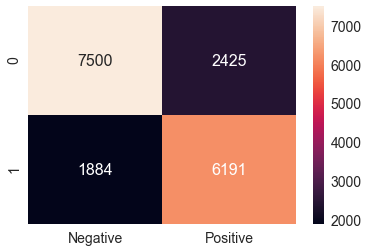

In [14]:
model = DecisionTreeGridSearch(train_features = bow_X_tr_reduced, train_class = Y_train, \
                                     test_features = bow_X_test_reduced, test_class = Y_test)

In [13]:
from sklearn import tree
import pydotplus
import collections

In [ ]:
dot_data = tree.export_graphviz(model.best_estimator_, \
                                feature_names=feature_names, \
                                out_file=None, \
                                filled=True, \
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')

<img src="tree2.png" width="120" height="200"/>

<img src="tree.png" width="120" height="200"/>

In [20]:
important_feature_indices = np.argsort(model.best_estimator_.feature_importances_)

In [26]:
important_feature_indices.size

68698

In [14]:
feature_names = count_vectorizer.get_feature_names()

## 10 important features

In [34]:
for i in range(1,10):
    print(feature_names[important_feature_indices[important_feature_indices.size - i]])

great
love
disappoint
best
delici
tast
bad
perfect
thought


In [ ]:
# Not executing tfidf as i know from BOW that large dimensions take a lot of time and provide results that are not satisfactory
#model = DecisionTreeGridSearch(train_features = tfidf_X_tr_reduced, train_class = Y_train, \
                                     #test_features = tfidf_X_test_reduced, test_class = Y_test)

In [8]:
Y_train = openfromfile(r'D:\Studies\AppliedAi\AmazonFoodReviews\Y_train')
Y_test = openfromfile(r'D:\Studies\AppliedAi\AmazonFoodReviews\Y_test')

Fitting 5 folds for each of 298 candidates, totalling 1490 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 1490 out of 1490 | elapsed: 20.0min finished


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy = 76.42222222222223
F1 Score = 73.93760746745271
Precision = 73.33414545011573
Recall = 74.55108359133126


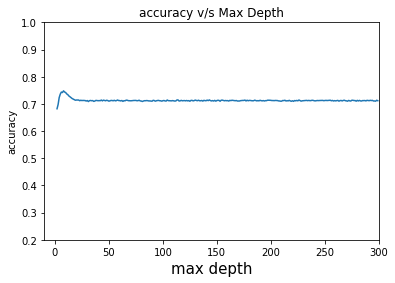

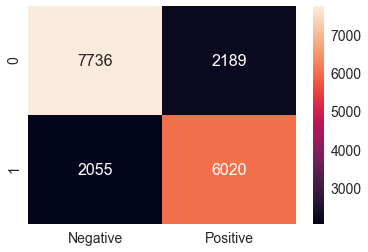

In [14]:
model = DecisionTreeGridSearch(train_features = avg_X_tr, train_class = Y_train, \
                                     test_features = avg_X_test, test_class = Y_test)

Fitting 5 folds for each of 298 candidates, totalling 1490 fits


[Parallel(n_jobs=1)]: Done 1490 out of 1490 | elapsed: 39.8min finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy = 74.5111111111111
F1 Score = 74.23629829290206
Precision = 74.43693693693693
Recall = 74.03673835125448


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


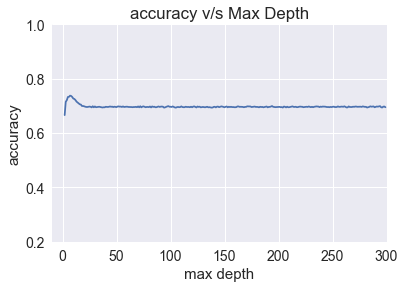

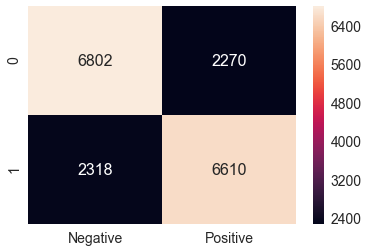

In [17]:
model = DecisionTreeGridSearch(train_features = avgtfidf_X_tr, train_class = Y_train, \
                                     test_features = avgtfidf_X_test, test_class = Y_test)

# Summary

In [35]:
result_df = pd.DataFrame(data = { "Vectorization" : ["BOW", "Average W2V", "Average tfidf"], \
                                  "Accuracy"      : ["76.211%" , "77.411%" , "74.5111%"]})

In [36]:
result_df

,Vectorization,Accuracy
0,BOW,76.211%
1,Average W2V,77.411%
2,Average tfidf,74.5111%
